# Evaluate outcome models

## Define models to evaluate

In [19]:
import outcome_models
import importlib

In [20]:
importlib.reload(outcome_models)

<module 'outcome_models' from '/Users/lovhag/Projects/yelp_causal_inference/outcome_models.py'>

In [22]:
models = {"baseline_model": outcome_models.get_baseline_model(), 
        "linear_model": outcome_models.get_linear_model(), 
        "logistic_regression_model": outcome_models.get_logistic_regression_model()}

## Load evaluation data

In [3]:
import pandas as pd
from result_help_functions import Data

In [4]:
df = pd.read_csv('saved_data/features_lovisa.csv')
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   test                   10114 non-null  int64  
 1   Z1                     10114 non-null  int64  
 2   Z2                     10114 non-null  int64  
 3   buffet                 10114 non-null  int64  
 4   $                      10114 non-null  int64  
 5   dessert                10114 non-null  int64  
 6   buffet_binary          10114 non-null  int64  
 7   $_binary               10114 non-null  int64  
 8   dessert_binary         10114 non-null  int64  
 9   is_positive_sentiment  10114 non-null  float64
 10  sentiment_certainty    10114 non-null  float64
 11  stars                  10114 non-null  int64  
 12  n_words                10114 non-null  int64  
 13  n_fans                 10114 non-null  int64  
 14  n_reviews              10114 non-null  int64  
 15  us

,test,Z1,Z2,buffet,$,dessert,buffet_binary,$_binary,dessert_binary,is_positive_sentiment,sentiment_certainty,stars,n_words,n_fans,n_reviews,useful,useful_discrete
0,1,1,1,1,0,0,1,0,0,1.0,0.999428,5,176,0,3,0,0
1,1,1,0,6,7,4,1,1,1,0.0,0.990075,4,940,330,1224,39,1
2,0,0,0,0,1,3,0,1,1,1.0,0.935575,4,131,113,1864,1,1
3,1,0,0,1,0,0,1,0,0,0.0,0.999454,1,18,0,6,0,0
4,1,0,0,1,0,0,1,0,0,1.0,0.999430,5,63,0,15,0,0


In [5]:
treatments = ['Z1', 'Z2']
confounders = ['is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews']

data = Data(df, treatments, confounders)

## Evaluate!

In [6]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
def get_treatment_model_crossval_scores(models, treatment_groups, X_data, Y_data):
    score_dict = {}

    for treatment in treatment_groups:
        score_dict[treatment] = {}
        for model_name, model in models.items():
            try: 
                score_dict[treatment][model_name] = cross_val_score(model, X_data[treatment], Y_data[treatment], cv=5)
            except Exception as e:
                print(f"Model evaluation failed for treatment: {treatment}")
                print("Caught exception: ")
                print(e)
    return score_dict

In [15]:
def plot_treatment_model_scores(score_dict):
    for treatment, model_scores in score_dict.items():
        try:
            plt.boxplot(x=model_scores.values(), labels=model_scores.keys())
            plt.title(treatment)
            plt.show()
        except Exception as e:
            print(f"Score plot failed for treatment: {treatment}")
            print("Caught exception: ")
            print(e)

### For discrete y

Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>


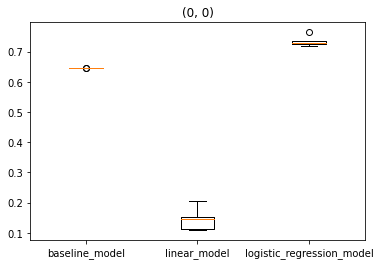

Score plot failed for treatment: (0, 1)
Caught exception: 
Dimensions of labels and X must be compatible


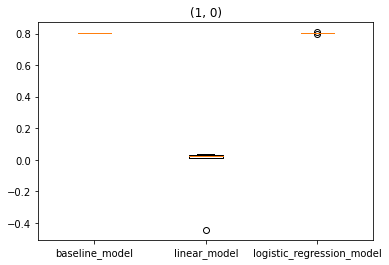

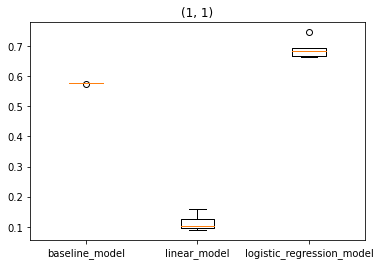

In [23]:
score_dict = get_treatment_model_crossval_scores(models, data.treatment_groups, data.X_test, data.Y_test_discrete)
plot_treatment_model_scores(score_dict)

### For continuous y

Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>


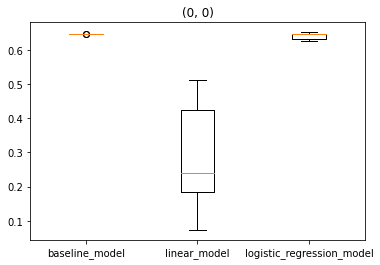

Score plot failed for treatment: (0, 1)
Caught exception: 
Dimensions of labels and X must be compatible


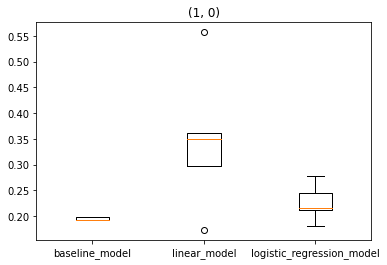

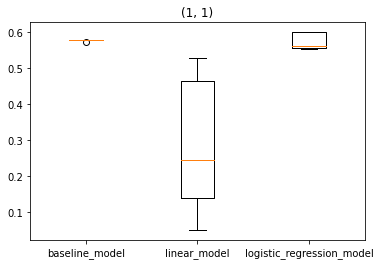

In [24]:
score_dict = get_treatment_model_crossval_scores(models, data.treatment_groups, data.X_test, data.Y_test)
plot_treatment_model_scores(score_dict)

##